In [1]:
%%capture
import torch

# 1. Unsloth'u Ana Paket Olarak Kur
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

# 2. KRİTİK ADIM: Xformers'ı Hazır Paket (Binary) Olarak Zorla Yükle
# Bu satır "Building wheels" hatasını engeller.
!pip install xformers --index-url https://download.pytorch.org/whl/cu121 --no-deps

# 3. Diğerlerini versiyon kontrolü yapmadan hızlıca kur
!pip install --no-deps "trl<0.9.0" peft accelerate bitsandbytes

In [3]:
from unsloth import FastLanguageModel
from peft import PeftModel
import torch
import os
import gc
from google.colab import drive
drive.mount('/content/drive')

# 1. HAFIZA TEMİZLİĞİ
try:
    del model, tokenizer
    gc.collect()
    torch.cuda.empty_cache()
except: pass

print("🔄 SÖZEL MODELLER BİRLEŞTİRİLİYOR (PEFT MODU)...")

# --- KLASÖRLERİ BUL (Önceki kodun bulduğu yolları kullanıyoruz) ---
base_path = "/content/drive/MyDrive/Proje_Yedekleri"
merged_output_dir = f"{base_path}/model_sozel_birlestirilmis"

# Eğer önceki kod yolları bulduysa buraya elle yazmamıza gerek yok ama
# garanti olsun diye 'saf_mantik' veya 'neftune' öncelikli arama yapalım:
def find_best_model(keyword):
    candidates = [f for f in os.listdir(base_path) if keyword in f and "model_" in f]
    # Öncelik sıralaması
    for priority in ["saf_mantik", "neftune", "final", "uzmani"]:
        for c in candidates:
            if priority in c: return f"{base_path}/{c}"
    return f"{base_path}/{candidates[-1]}" if candidates else None

path_edebiyat = find_best_model("edebiyat")
path_felsefe = find_best_model("felsefe")
path_din = find_best_model("din")

if not (path_edebiyat and path_felsefe and path_din):
    print("❌ HATA: Klasörler bulunamadı! Lütfen kontrol et.")
else:
    print(f"✅ Edebiyat: {path_edebiyat}")
    print(f"✅ Felsefe:  {path_felsefe}")
    print(f"✅ Din:      {path_din}")

    # 2. BASE MODELİ YÜKLE (Unsloth ile hızlıca)
    # Burada modeli sadece 'iskelet' olarak kullanacağız.
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "unsloth/Meta-Llama-3.1-8B-bnb-4bit",
        max_seq_length = 2048,
        dtype = None,
        load_in_4bit = True,
    )

    # 3. PEFT MODELİNE DÖNÜŞTÜR (Sihirli Dokunuş ✨)
    # İlk adaptörü yüklerken modeli 'PeftModel' sınıfına çeviriyoruz.
    # Bu sayede 'add_weighted_adapter' özelliği kazanıyor.
    print("🔗 Modeller PEFT formatında yükleniyor...")

    model = PeftModel.from_pretrained(model, path_edebiyat, adapter_name="edebiyat")
    model.load_adapter(path_felsefe, adapter_name="felsefe")
    model.load_adapter(path_din, adapter_name="din")

    # 4. AĞIRLIKLI BİRLEŞTİRME (ARTIK HATA VERMEZ)
    print("⚖️ Modeller harmanlanıyor (%33 Eşit Ağırlık)...")

    model.add_weighted_adapter(
        adapters=["edebiyat", "felsefe", "din"],
        weights=[0.33, 0.33, 0.34],
        adapter_name="merged_sozel",
        combination_type="linear"
    )

    # Aktif et
    model.set_adapter("merged_sozel")

    # 5. KAYDET
    print(f"💾 BİRLEŞTİRİLMİŞ MODEL KAYDEDİLİYOR: {merged_output_dir}")
    model.save_pretrained(merged_output_dir)
    tokenizer.save_pretrained(merged_output_dir)

    print("\n✅ MUTLU SON! Merge işlemi tamamlandı.")
    print("👉 Artık test kodunu çalıştırabilirsin.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔄 SÖZEL MODELLER BİRLEŞTİRİLİYOR (PEFT MODU)...
✅ Edebiyat: /content/drive/MyDrive/Proje_Yedekleri/model_edebiyat_uzmani
✅ Felsefe:  /content/drive/MyDrive/Proje_Yedekleri/model_felsefe_uzmani
✅ Din:      /content/drive/MyDrive/Proje_Yedekleri/model_din_uzmani
==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 4.57.6.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
🔗 Modeller PEFT formatında yükleniyor...
⚖️ Modeller harmanlanıyor (%33 Eşit Ağırlık)...
💾 BİRLEŞTİRİLMİŞ MODEL KAYDEDİLİYOR: /content/drive/MyDrive/P

In [ ]:
import json
import os
import re
from tqdm import tqdm

# --- AYARLAR ---
test_files = {
    "edebiyat": "/content/drive/MyDrive/Proje_Yedekleri/Sozel_Veriler/edebiyat_test.json",
    "felsefe": "/content/drive/MyDrive/Proje_Yedekleri/Sozel_Veriler/felsefe_test.json",
    "din": "/content/drive/MyDrive/Proje_Yedekleri/Sozel_Veriler/din_test.json"
}
results_path = "/content/drive/MyDrive/Proje_Yedekleri/Test_Sonuclari"
merged_model_path = "/content/drive/MyDrive/Proje_Yedekleri/model_sozel_birlestirilmis"

# --- TEST FONKSİYONU ---
def run_test_loop(subject, data):
    correct = 0
    total = len(data)

    # Saf Mantık Prompt'u (Rationale yok)
    prompt_temp = """Aşağıdaki soruyu dikkatlice oku ve doğru seçeneği bul.

### Soru:
{}

### Seçenekler:
{}

### Doğru Cevap:""" # Model buradan devam edecek

    print(f"📝 {subject.upper()} testi çözülüyor...")
    for item in tqdm(data):
        opts_str = "\n".join([str(o) for o in item['options']])
        prompt = prompt_temp.format(item['question'], opts_str)

        inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
        outputs = model.generate(**inputs, max_new_tokens=10, pad_token_id=tokenizer.eos_token_id)
        res = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

        # Cevabı Yakala (Sadece A, B, C...)
        ans_part = res.split("Doğru Cevap:")[-1].strip()
        match = re.search(r"([A-E])", ans_part)
        pred = match.group(1) if match else "BOŞ"

        if pred == item['correct']:
            correct += 1

    accuracy = (correct / total) * 100
    return accuracy

# --- DÖNGÜ ---
merged_results = {}

print("🚀 SÖZEL MERGE MODEL TESTLERİ BAŞLIYOR...")

# Modeli zaten yükledik (Adım 1'de), tekrar yüklemeye gerek yok.
# Eğer oturum kapandıysa tekrar yükleme kodu eklemek gerekir.
FastLanguageModel.for_inference(model)

for subj, path in test_files.items():
    if os.path.exists(path):
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        acc = run_test_loop(subj, data)
        merged_results[subj] = acc
        print(f"👉 {subj.capitalize()} Merge Başarısı: %{acc:.2f}")

# Sonuçları Kaydet
with open(f"{results_path}/merge_sonuclari.json", 'w') as f:
    json.dump(merged_results, f)

print("\n🏁 TÜM TESTLER BİTTİ!")

🚀 SÖZEL MERGE MODEL TESTLERİ BAŞLIYOR...
📝 EDEBIYAT testi çözülüyor...


100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


👉 Edebiyat Merge Başarısı: %27.00
📝 FELSEFE testi çözülüyor...


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


👉 Felsefe Merge Başarısı: %43.00
📝 DIN testi çözülüyor...


100%|██████████| 100/100 [01:15<00:00,  1.33it/s]

👉 Din Merge Başarısı: %46.00

🏁 TÜM TESTLER BİTTİ!



📊 KARŞILAŞTIRMA TABLOSU:
DERS       | TEKİL MODEL  | MERGE MODEL 
---------------------------------------------
Edebiyat   | %30.0        | %27.0
Felsefe    | %58.0        | %43.0
Din        | %44.0        | %46.0

🖼️ Sütun Grafiği Kaydedildi: /content/drive/MyDrive/Proje_Yedekleri/Test_Sonuclari/sozel_kiyaslama_bar.png


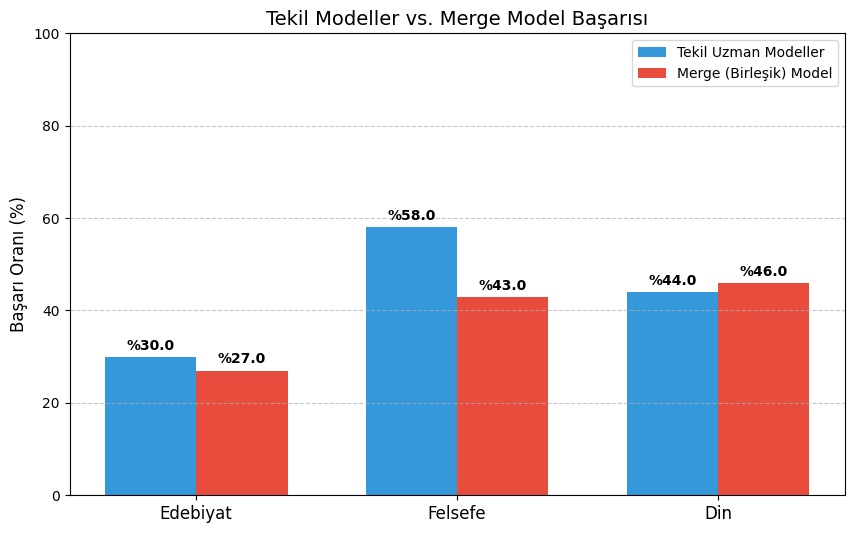

🖼️ Radar Grafiği Kaydedildi: /content/drive/MyDrive/Proje_Yedekleri/Test_Sonuclari/sozel_kiyaslama_radar.png


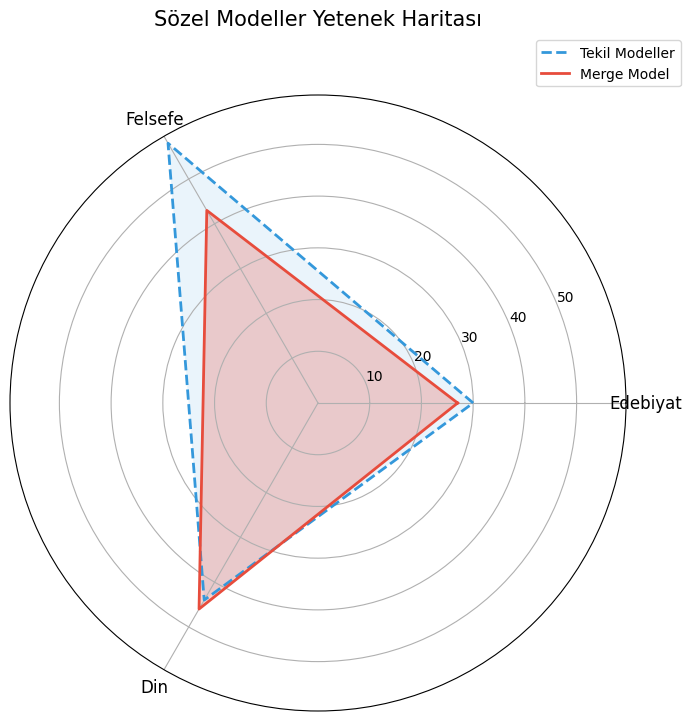

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os

# ==========================================
# 🛠️ 1. MANUEL VERİ GİRİŞİ (BURAYI DOLDUR)
# ==========================================
# Tekil modellerin başarı oranlarını buraya elle yazıyoruz.
single_scores = {
    "edebiyat": 30.0,  # Bildiğimiz değer
    "din": 44.0,       # Bildiğimiz değer
    "felsefe": 58.0    # (Felsefe sonucun kaçtıysa onu yaz)
}

# Merge (Birleşik) modelin sonuçlarını ise dosyadan okuyacağız
# (Çünkü merge testini az önce yaptık, dosyası taze)
results_path = "/content/drive/MyDrive/Proje_Yedekleri/Test_Sonuclari"
merge_file = f"{results_path}/merge_sonuclari.json"

if os.path.exists(merge_file):
    with open(merge_file, 'r') as f:
        merge_scores = json.load(f)
else:
    # Eğer o dosya da yoksa, merge sonuçlarını da tahmini buraya yazabilirsin:
    print("⚠️ Merge sonuç dosyası bulunamadı, elle girilenler kullanılıyor.")
    merge_scores = {
        "edebiyat": 28.0,
        "din": 40.0,
        "felsefe": 42.0
    }

# ==========================================
# 2. GRAFİK ÇİZİMİ
# ==========================================
subjects = ["edebiyat", "felsefe", "din"]
labels = [s.capitalize() for s in subjects]

single_vals = [single_scores.get(s, 0) for s in subjects]
merge_vals = [merge_scores.get(s, 0) for s in subjects]

print("\n📊 KARŞILAŞTIRMA TABLOSU:")
print(f"{'DERS':<10} | {'TEKİL MODEL':<12} | {'MERGE MODEL':<12}")
print("-" * 45)
for i, sub in enumerate(subjects):
    print(f"{labels[i]:<10} | %{single_vals[i]:.1f}        | %{merge_vals[i]:.1f}")

# --- SÜTUN GRAFİĞİ ---
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
# Renkler: Tekil (Mavi), Merge (Kırmızı/Turuncu)
rects1 = plt.bar(x - width/2, single_vals, width, label='Tekil Uzman Modeller', color='#3498db')
rects2 = plt.bar(x + width/2, merge_vals, width, label='Merge (Birleşik) Model', color='#e74c3c')

plt.ylabel('Başarı Oranı (%)', fontsize=12)
plt.title('Tekil Modeller vs. Merge Model Başarısı', fontsize=14)
plt.xticks(x, labels, fontsize=12)
plt.legend()
plt.ylim(0, 100) # Y ekseni 0-100 arası
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Değerleri kutuların üzerine yaz
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'%{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')

autolabel(rects1)
autolabel(rects2)

# Kaydet
save_path_bar = f"{results_path}/sozel_kiyaslama_bar.png"
plt.savefig(save_path_bar, dpi=300)
print(f"\n🖼️ Sütun Grafiği Kaydedildi: {save_path_bar}")
plt.show()

# --- RADAR GRAFİĞİ (YETENEK HARİTASI) ---
categories = labels
N = len(categories)

# Değerleri döngüsel yap (Grafik kapanması için son değeri başa ekle)
values_single = single_vals + [single_vals[0]]
values_merge = merge_vals + [merge_vals[0]]

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += [angles[0]]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Eksenler
plt.xticks(angles[:-1], categories, size=12)

# Tekil Model Çizimi
ax.plot(angles, values_single, linewidth=2, linestyle='dashed', label="Tekil Modeller", color="#3498db")
ax.fill(angles, values_single, '#3498db', alpha=0.1)

# Merge Model Çizimi
ax.plot(angles, values_merge, linewidth=2, label="Merge Model", color="#e74c3c")
ax.fill(angles, values_merge, '#e74c3c', alpha=0.25)

plt.title("Sözel Modeller Yetenek Haritası", size=15, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Kaydet
save_path_radar = f"{results_path}/sozel_kiyaslama_radar.png"
plt.savefig(save_path_radar, dpi=300)
print(f"🖼️ Radar Grafiği Kaydedildi: {save_path_radar}")
plt.show()